In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

from google.colab import drive

%matplotlib inline

drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Part 1

##Part 1.1 Data Understanding

###Part 1.1.a - Read the Data set “data_add_nik.csv” and print the shape of the dataset. 

In [26]:
nike_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised Learning Project/data_add_nik.csv')
nike_df.shape

(3268, 8)

###Part 1.1.b - Check if there is any redundant column in the dataset and drop them. 

In [27]:
nike_df.head()

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Rating,Reviews
0,Women's adidas Originals NMD_Racer Primeknit S...,AH2430,14999,7499,50,Adidas Adidas ORIGINALS,4.8,41
1,Women's adidas Originals Sleek Shoes,G27341,7599,3799,50,Adidas ORIGINALS,3.3,24
2,Women's adidas Swim Puka Slippers,CM0081,999,599,40,Adidas CORE / NEO,2.6,37
3,Women's adidas Sport Inspired Questar Ride Shoes,B44832,6999,3499,50,Adidas CORE / NEO,4.1,35
4,Women's adidas Originals Taekwondo Shoes,D98205,7999,3999,50,Adidas ORIGINALS,3.5,72


In [28]:
nike_df = nike_df.drop(['Product Name','Product ID'],axis=1)
nike_df.head()

,Listing Price,Sale Price,Discount,Brand,Rating,Reviews
0,14999,7499,50,Adidas Adidas ORIGINALS,4.8,41
1,7599,3799,50,Adidas ORIGINALS,3.3,24
2,999,599,40,Adidas CORE / NEO,2.6,37
3,6999,3499,50,Adidas CORE / NEO,4.1,35
4,7999,3999,50,Adidas ORIGINALS,3.5,72


###Part 1.1.c - Check if there are any duplicate records in the dataset. If yes, drop them.

In [29]:
duplicates = nike_df.duplicated()
duplicate_rows = nike_df[duplicates]
duplicate_rows.shape

(277, 6)

In [30]:
# droping duplicate records and keep the first occurrence
nike_df = nike_df.drop_duplicates(keep='first')
nike_df.shape

(2991, 6)

###Part 1.1 d - Check the 5 points summary of the whole data and share your observations.

In [31]:
nike_df.describe()

,Listing Price,Sale Price,Discount,Rating,Reviews
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000
mean,7286.886994,5761.971581,29.254430,3.387329,44.001672
std,4505.625036,4073.083362,22.087068,1.237679,30.617955
min,0.000000,449.000000,0.000000,0.000000,0.000000
25%,4599.000000,2999.000000,0.000000,2.700000,16.000000
50%,6599.000000,4559.000000,40.000000,3.600000,43.000000
75%,8999.000000,7599.000000,50.000000,4.400000,70.000000
max,29999.000000,36500.000000,60.000000,5.000000,223.000000


<Axes: title={'center': 'Rating'}>

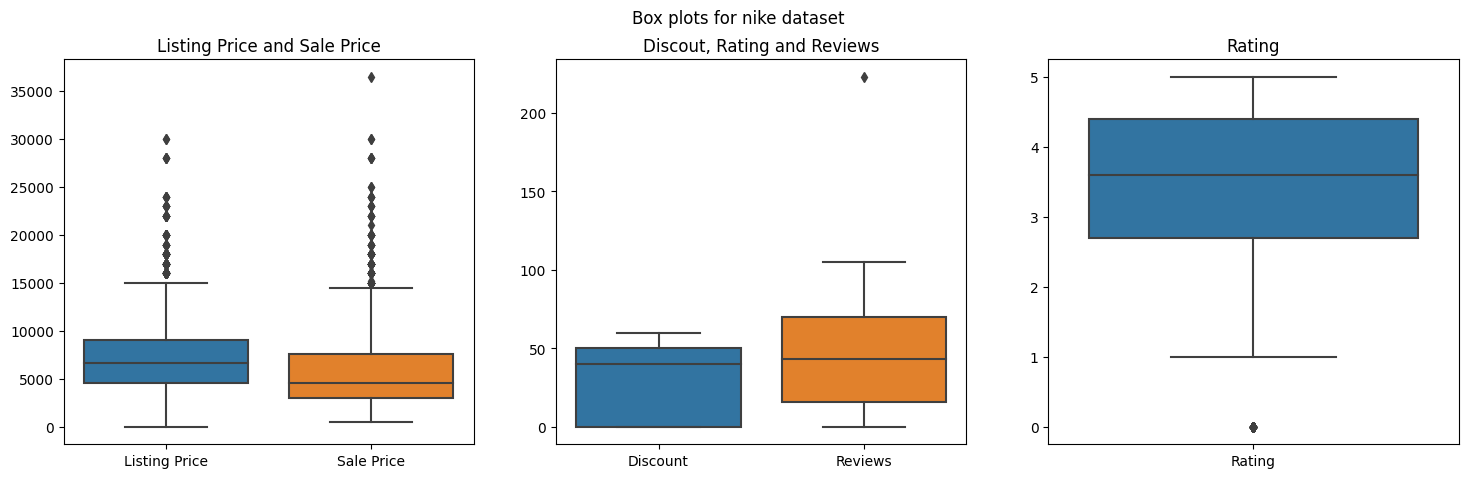

In [32]:
fig, axes = plt.subplots(1, 3,figsize=(18,5))
fig.suptitle('Box plots for nike dataset')

axes[0].set_title('Listing Price and Sale Price')
columns = ['Listing Price','Sale Price']
sns.boxplot(ax=axes[0], data = nike_df[columns])

axes[1].set_title('Discout, Rating and Reviews')
columns = ['Discount',	'Reviews']
sns.boxplot(ax=axes[1], data = nike_df[columns])

axes[2].set_title('Rating')
columns = ['Rating']
sns.boxplot(ax=axes[2], data = nike_df[columns])

Following are the observations
1.   Listing and Sale price are affected by the outliers
2.   Listing Price has the value 0 as per the above chart which is not correct. Price can not be 0. It can be missing value. Due to which the outliers are more
3. Same with the Sale price. Sale price can not be 0.
4. Listing and Sale price are Positively skewed (Right Skewed)
5. Discount starts from 0 and can geos up to 60%. Distribution looks negatively skewed(Left skewed)
6. Review is normally destributed. 
7. Rating range is from 0 to 5. Majority of the rating is lies under 3.5. Rating is also negatively skewed and has the outleir 0



##Part 1.2 Exploratory Data Analysis

###Part 1.2.a - Check how many products have Listing_price ‘0’. Check it’s 5 points summary and share your insights.

In [33]:
zero_price_products = nike_df[nike_df['Listing Price'] == 0]

# Count the number of products with Listing_price '0'
num_zero_price_products = zero_price_products.shape[0]
print(f"Number of products with Listing_price '0': {num_zero_price_products}")

# Calculate the five-number summary for products with Listing_price '0'
summary_stats = zero_price_products.describe()
print("\nFive-Number Summary:")
print(summary_stats)

Number of products with Listing_price '0': 214

Five-Number Summary:
       Listing Price    Sale Price  Discount      Rating     Reviews
count          214.0    214.000000     214.0  214.000000  214.000000
mean             0.0  11375.397196       0.0    3.653271   12.766355
std              0.0   5098.811788       0.0    1.591457   23.547606
min              0.0   1595.000000       0.0    0.000000    0.000000
25%              0.0   7995.000000       0.0    3.425000    1.000000
50%              0.0  10245.000000       0.0    4.250000    4.000000
75%              0.0  14995.000000       0.0    4.700000   13.000000
max              0.0  36500.000000       0.0    5.000000  223.000000



Following are insights of the records having listing price 0
*   There are 214 rows which contains the listing value as 0
*   There is no discont, no review and no rating provided for the product which has listing price 0
*   The listing price started missing over the sale price starts from the 1595





###Part 1.2.b - Records having Listing_price ‘0’, replace them with Sale_Price of that record.

In [34]:
zero_price_records = nike_df[nike_df['Listing Price'] == 0]
nike_df.loc[nike_df['Listing Price'] == 0, 'Listing Price'] = zero_price_records['Sale Price']

#Check how many listing price are having 0
zero_price_products = nike_df[nike_df['Listing Price'] == 0]
num_zero_price_products = zero_price_products.shape[0]
print(f"Number of products with Listing price '0': {num_zero_price_products}")

Number of products with Listing price '0': 0


In [35]:
nike_df.Brand.value_counts()

Adidas CORE / NEO           1107
Adidas ORIGINALS             903
Adidas SPORT PERFORMANCE     605
Nike                         375
Adidas Adidas ORIGINALS        1
Name: Brand, dtype: int64

In [36]:
nike_df.loc[nike_df['Brand'] != 'Nike', 'Brand'] = 'Adidas'
nike_df.Brand.value_counts()

Adidas    2616
Nike       375
Name: Brand, dtype: int64

Converted the brand to have only Nike and Adidas and removed all adidas sub category

###Part 1.2.c - Check and print feature-wise percentage of missing values present in the data and impute with the best  suitable approach

In [37]:
missing_percentages = nike_df.isna().mean() * 100
print("Missing Value Percentages:")
print(missing_percentages)

Missing Value Percentages:
Listing Price    0.0
Sale Price       0.0
Discount         0.0
Brand            0.0
Rating           0.0
Reviews          0.0
dtype: float64


There is no missing value in the dataset

###Part 1.2.d - Perform univariate analysis on the data and share your insights

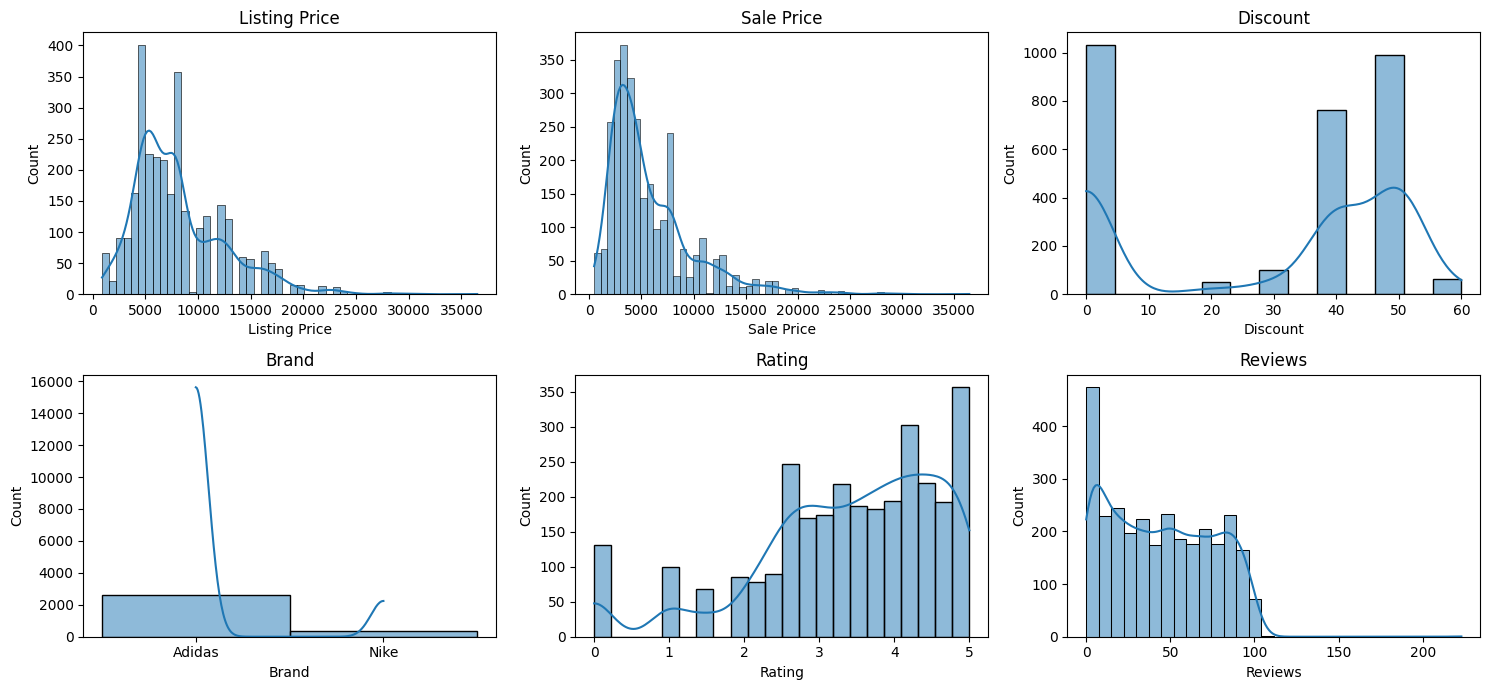

In [38]:
columns = nike_df.columns.tolist()

rows = 2;cols = 3;i=0;j=0
fig, axes = plt.subplots(rows,cols, figsize=(15, 7))

for column in (columns):
    if j>rows :
      i+=1;
      j=0;
      
    sns.histplot(data=nike_df, x=column, kde=True, ax=axes[i,j])
    axes[i,j].set_title(column)
    j+=1

plt.tight_layout()
plt.show()

Following are the univariate analysis on the data


1. Listing price is left skewed
2. Sale price is also left skewed but it is uniformly distributed
3. Discount is not provided for most of the product. 
4. 40% to 50% is the discount commonly given
5. Rating is Slighly right skwed
6. The sample dataframe has more no of rows for the Adidas and very less for nike



###Part 1.2.e - Perform bivariate and multivariate analysis and share your insights

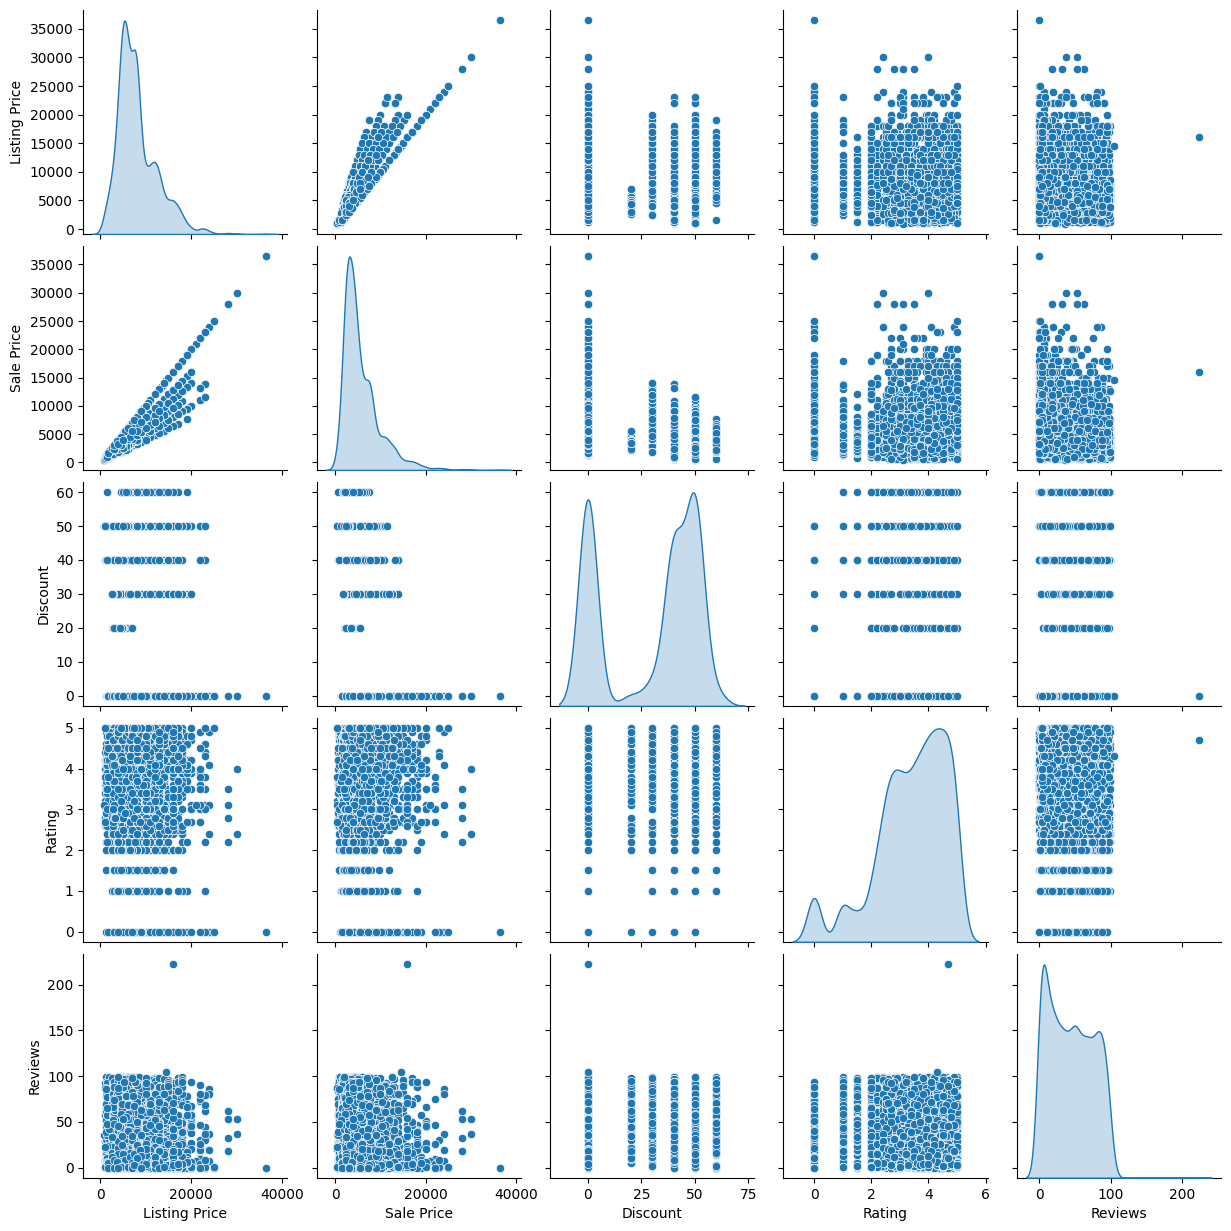

In [39]:
sns.pairplot(data = nike_df, vars = ['Listing Price','Sale Price','Discount','Rating','Reviews'],diag_kind='kde');

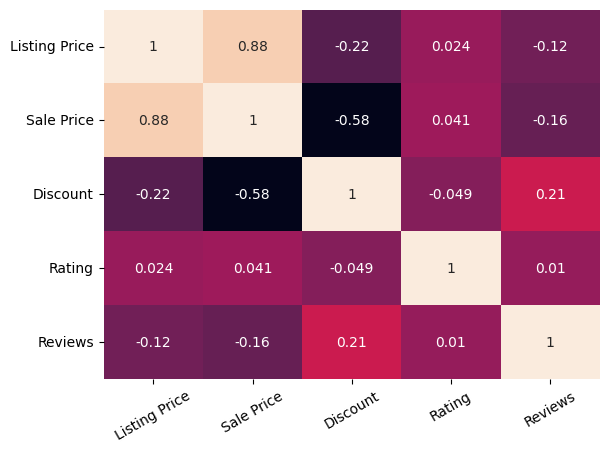

In [40]:
plt.xticks(rotation=30)
sns.heatmap(data = nike_df[['Listing Price','Sale Price','Discount','Rating','Reviews']].corr(), annot=True,cbar=False);

Following are the bivariate and multivariate analysis insights


1.   Listing and the Salre Price are poitively corelated
2.   Rest of the properties are independet and has no co relation to each other
3.   Discount represents the bimodal
4.   Sale price and discount is negatively co-related as per the HeatMap



##Part 1.3 Data Preprocessing

###Part 1.3.a - Scale all the numeric variables using suitable technique

In [41]:
# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(nike_df['Brand'], prefix='Brand')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([nike_df, one_hot_encoded], axis=1)
df_encoded = df_encoded.drop(['Brand'],axis=1)
df_encoded.head()

,Listing Price,Sale Price,Discount,Rating,Reviews,Brand_Adidas,Brand_Nike
0,14999,7499,50,4.8,41,1,0
1,7599,3799,50,3.3,24,1,0
2,999,599,40,2.6,37,1,0
3,6999,3499,50,4.1,35,1,0
4,7999,3999,50,3.5,72,1,0


In [42]:
df_scaled = df_encoded.apply(zscore)
df_scaled.head()

,Listing Price,Sale Price,Discount,Rating,Reviews,Brand_Adidas,Brand_Nike
0,1.587594,0.426537,0.939420,1.141578,-0.098053,0.378614,-0.378614
1,-0.115481,-0.482018,0.939420,-0.070570,-0.653375,0.378614,-0.378614
2,-1.634439,-1.267795,0.486591,-0.636240,-0.228717,0.378614,-0.378614
3,-0.253568,-0.555685,0.939420,0.575909,-0.294049,0.378614,-0.378614
4,-0.023423,-0.432907,0.939420,0.091050,0.914594,0.378614,-0.378614


##Part 1.4 K-Means Clustering

###Part 1.4.a - Apply K-Means clustering for 2 to 10 clusters

In [43]:
clusters=range(2,11)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df_scaled)
    prediction=model.predict(df_scaled)
    meanDistortions.append(sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled
                           .shape[0])

###Part 1.4.b - Plot a visual and find elbow point. 

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

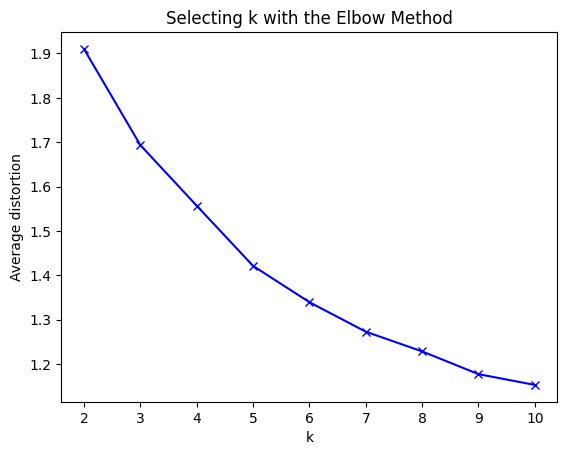

In [44]:
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

###Part 1.4.c - Considering the above visual, mention which are the optimal clusters

From the above visual we can say that the optimal k = 5

###Part 1.4.d - Calculate silhouette scores of all K clusters 2 to 10

In [45]:
features = df_scaled.values
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(features);
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For K = {k}, the silhouette score is: {silhouette_avg}")

For K = 2, the silhouette score is: 0.5317177839609517
For K = 3, the silhouette score is: 0.3222031801570808
For K = 4, the silhouette score is: 0.3113891287273003
For K = 5, the silhouette score is: 0.28075275001705985
For K = 6, the silhouette score is: 0.28377120291260555
For K = 7, the silhouette score is: 0.29616445499912725
For K = 8, the silhouette score is: 0.2978309041840331
For K = 9, the silhouette score is: 0.28797490985052887
For K = 10, the silhouette score is: 0.2894985796932511


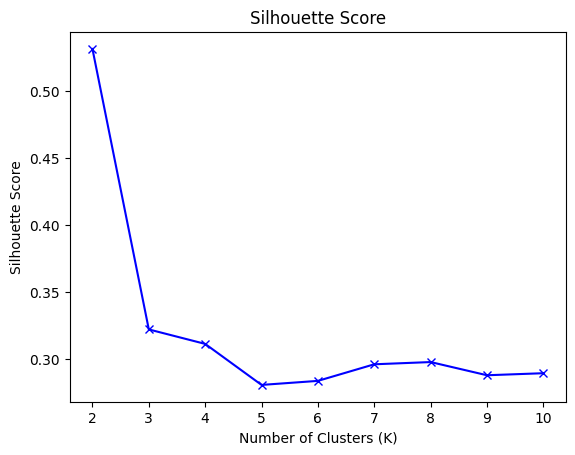

In [46]:
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

###Part 1.4.e - Considering 4.c and 4.d, what is the optimal value of K?

Considering 4.c and 4.d The optimal value of k = 5

###Part 1.4.f - Train a K-means clustering model once again on the optimal number of clusters

In [47]:
final_model=KMeans(5)
final_model.fit(df_scaled)
prediction=final_model.predict(df_scaled)

###Part 1.4.g - Add K-means cluster labels to the original data.

In [48]:
nike_df["GROUP"] = prediction
print("Groups Assigned : \n")
nike_df.head(10)

Groups Assigned : 



,Listing Price,Sale Price,Discount,Brand,Rating,Reviews,GROUP
0,14999,7499,50,Adidas,4.8,41,0
1,7599,3799,50,Adidas,3.3,24,4
2,999,599,40,Adidas,2.6,37,4
3,6999,3499,50,Adidas,4.1,35,4
4,7999,3999,50,Adidas,3.5,72,1
5,4799,1920,60,Adidas,1.0,45,4
6,4799,2399,50,Adidas,4.4,2,4
7,999,599,40,Adidas,2.8,7,4
8,5599,2799,50,Adidas,4.5,16,4
9,6599,3959,40,Adidas,4.0,39,4


###Part 1.4.h - Do cluster profiling and display

array([[<Axes: title={'center': 'Discount'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Listing Price'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Rating'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Reviews'}, xlabel='[GROUP]'>],
       [<Axes: title={'center': 'Sale Price'}, xlabel='[GROUP]'>,
        <Axes: >, <Axes: >, <Axes: >]], dtype=object)

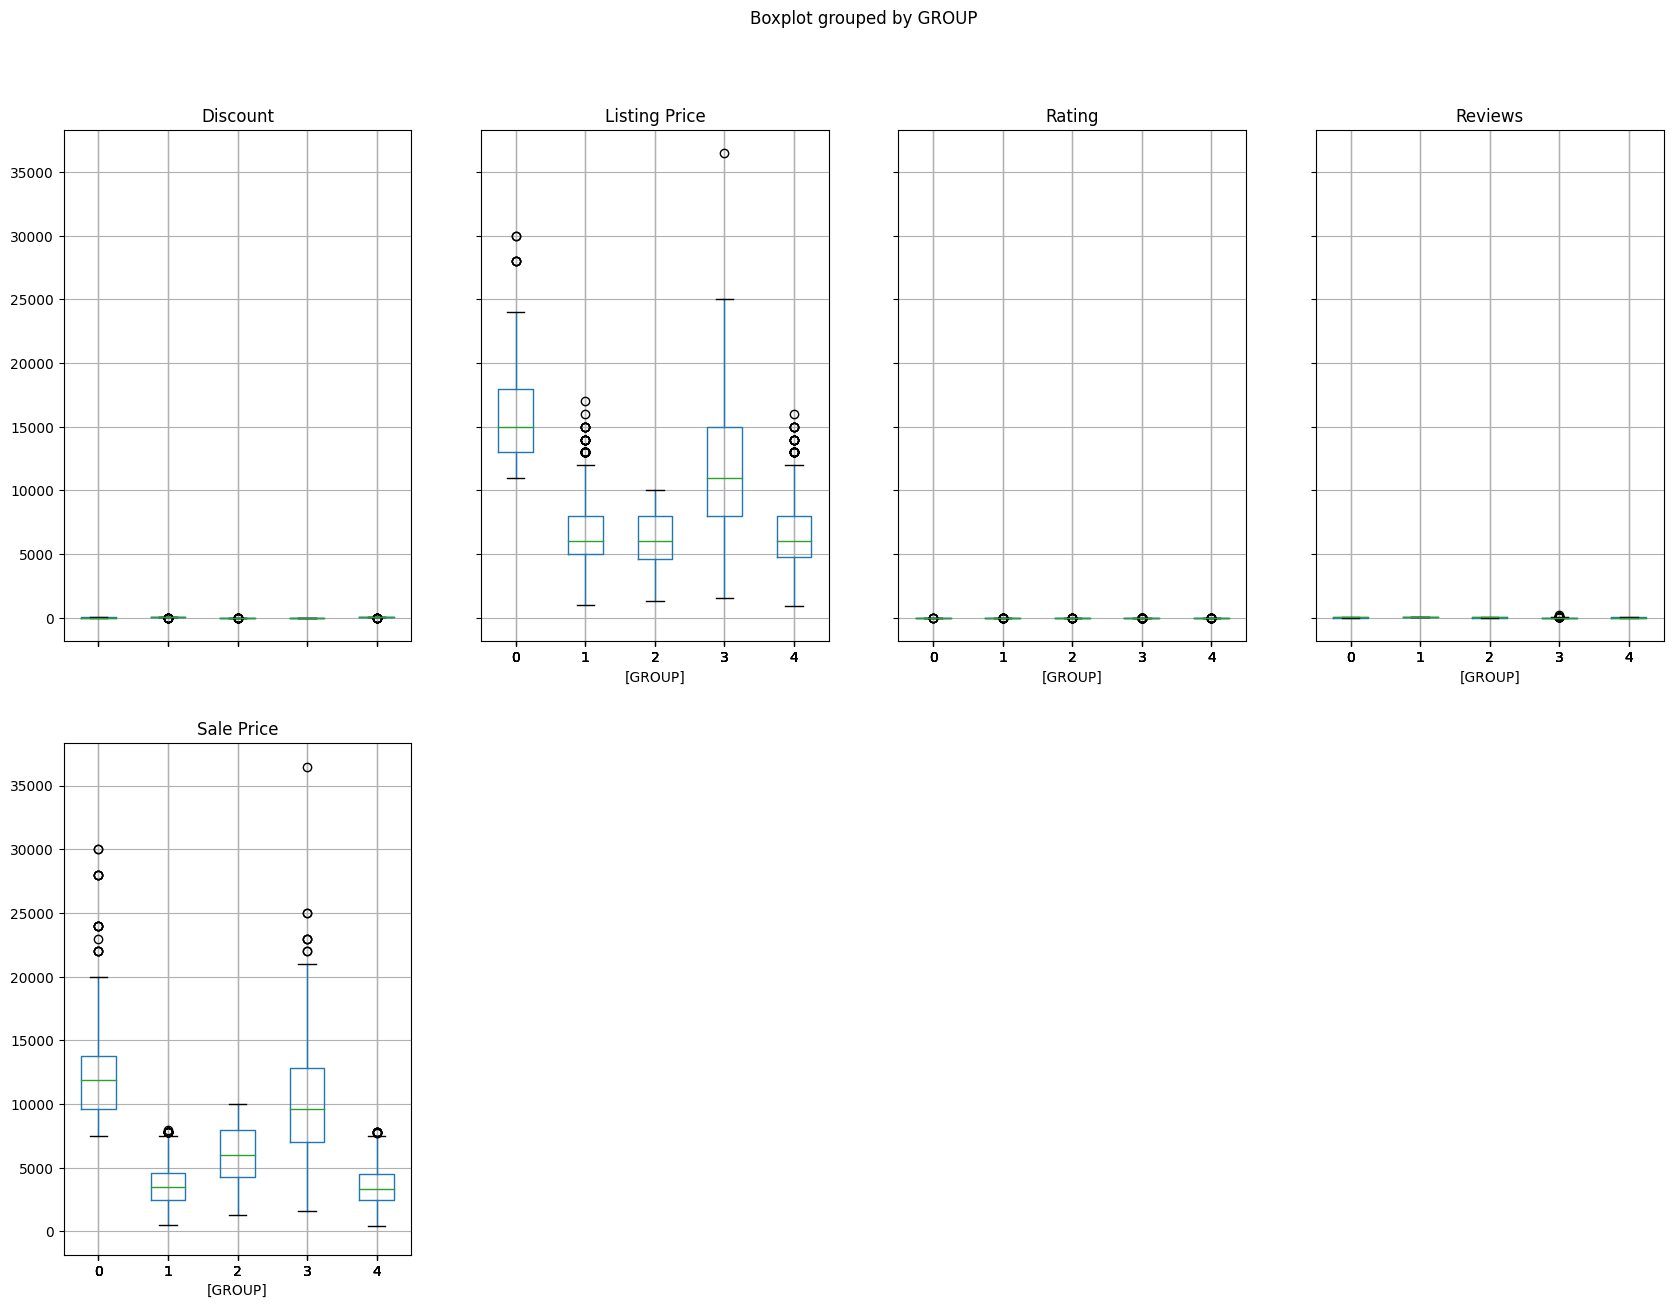

In [49]:
nike_df.boxplot(by = 'GROUP',  layout=(2,4), figsize=(20, 15))

###Part 1.4.i - Share your insights on the clusters which are built. Here try to explain what each cluster is saying

In [50]:
nike_df.describe()

,Listing Price,Sale Price,Discount,Rating,Reviews,GROUP
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000
mean,8100.773654,5761.971581,29.254430,3.387329,44.001672,2.205617
std,4345.809490,4073.083362,22.087068,1.237679,30.617955,1.408354
min,899.000000,449.000000,0.000000,0.000000,0.000000,0.000000
25%,4999.000000,2999.000000,0.000000,2.700000,16.000000,1.000000
50%,7495.000000,4559.000000,40.000000,3.600000,43.000000,2.000000
75%,9999.000000,7599.000000,50.000000,4.400000,70.000000,4.000000
max,36500.000000,36500.000000,60.000000,5.000000,223.000000,4.000000


Cluster 0 (GROUP 0):

1. This cluster has the lowest mean 'Listing Price' and 'Sale Price' compared to the other clusters.
2. The mean 'Discount' for this cluster is 0, indicating that there might be no discount offered.
3. The mean 'Rating' is relatively low at 3.39, suggesting moderate customer satisfaction.
4. The mean 'Reviews' count is 44, indicating a moderate level of customer feedback.

Cluster 2 (GROUP 2):

1. This cluster has a higher mean 'Listing Price' and 'Sale Price' compared to Cluster 0.
2. The mean 'Discount' for this cluster is 29.25, suggesting a moderate discount offered.
3. The mean 'Rating' is 3.39, which is similar to Cluster 0, indicating moderate customer satisfaction.
4. The mean 'Reviews' count is 44, again similar to Cluster 0.


Cluster 4 (GROUP 4):

1. This cluster has the highest mean 'Listing Price' and 'Sale Price' among the clusters.
2. The mean 'Discount' for this cluster is 29.25, similar to Cluster 2, indicating a moderate discount offered.
3. The mean 'Rating' is relatively higher at 3.39, suggesting higher customer satisfaction compared to Clusters 0 and 2.
4. The mean 'Reviews' count is 44, similar to the other clusters.
Based on these insights, it appears that the clustering has grouped the data into three clusters (0, 2, and 4) based on similar pricing, discount, rating, and review characteristics. 
5. Cluster 0 represents products with lower prices, possibly with no discount, and moderate customer satisfaction. Cluster 2 and Cluster 4 represent products with higher prices, similar discount levels, and relatively higher customer satisfaction.

###Part 1.4.j - Considering the cluster profiles, give any 2-business recommendation which will help the business.

1. Target Cluster 4 Customers for Upselling: <br>
Cluster 4 represents products with higher prices, moderate discounts, and relatively higher customer satisfaction. This cluster could indicate a segment of customers who are willing to pay more for products and are generally satisfied with their purchases. The business can leverage this opportunity by upselling additional products or offering premium versions of their existing products to customers in this cluster. By targeting these customers with personalized recommendations and exclusive offers, the business can potentially increase their average transaction value and overall revenue.

2. Improve Customer Satisfaction in Cluster 0: <br>
Cluster 0 represents products with lower prices, possibly no discount, and moderate customer satisfaction. It appears that customers in this cluster might have lower expectations due to the lower price range. To enhance the business's performance, it is recommended to focus on improving customer satisfaction within this cluster. This can be achieved by ensuring product quality, providing excellent customer service, and actively seeking feedback from customers in Cluster 0. By addressing any potential pain points and meeting customer expectations, the business can improve customer loyalty, drive positive word-of-mouth, and potentially attract new customers.

#Part 2

##Part 2.1 Data Understanding

###Part 2.1.a - Read the Data set “country_stats.csv” and print the shape of the dataset.

In [51]:
country_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised Learning Project/country_stats.csv')
country_df.head(5)

,country,Region,Surface area,Population in thousands,Population density,GDP: Gross domestic product,Economy: Agriculture,Economy: Industry,Economy: Services and other activity,International trade: Balance,Health: Total expenditure,Education: Government expenditure,Mobile-cellular subscriptions,Individuals using the Internet
0,Afghanistan,SouthernAsia,652864.0,35530,54.4,20270.0,23.3,23.3,53.3,-2110.0,8.2,3.3,61.6,42.0
1,Albania,SouthernEurope,28748.0,2930,106.9,11541.0,22.4,26.0,51.7,-2707.0,5.9,3.5,106.4,130.0
2,Algeria,NorthernAfrica,2381741.0,41318,17.3,164779.0,12.2,37.3,50.5,-17099.0,7.2,NaN,113.0,135.0
3,American Samoa,Polynesia,199.0,56,278.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0
4,Andorra,SouthernEurope,468.0,77,163.8,2812.0,0.5,10.8,88.6,-1255.0,8.1,3.3,88.1,13.0


###Part 2.1.b - Print 5 points summary statistics of the data and share your observations

In [52]:
country_df.describe()

,Surface area,Population in thousands,Population density,GDP: Gross domestic product,Economy: Agriculture,Economy: Industry,Economy: Services and other activity,International trade: Balance,Health: Total expenditure,Education: Government expenditure,Mobile-cellular subscriptions,Individuals using the Internet
count,2.260000e+02,2.290000e+02,229.000000,2.080000e+02,206.000000,208.000000,208.000000,210.000000,190.000000,148.000000,209.000000,228.000000
mean,5.932100e+05,3.275679e+04,462.824891,3.538963e+05,11.481553,27.565385,61.089423,-683.861905,6.763158,4.570946,107.360287,200.017544
std,1.796021e+06,1.332751e+05,2305.384253,1.548160e+06,12.100601,13.124423,15.504890,73188.172715,2.798017,1.781128,43.063860,296.444644
min,1.000000e-05,1.000000e+00,0.100000,3.300000e+01,0.000010,4.000000,14.900000,-796494.000000,1.500000,1.000000,7.000000,1.000000
25%,4.306500e+03,4.310000e+02,35.900000,4.987000e+03,2.400000,19.075000,51.000000,-3501.250000,4.825000,3.200000,79.400000,55.750000
50%,8.373550e+04,5.448000e+03,88.100000,2.387100e+04,7.200000,26.450000,61.300000,-984.000000,6.350000,4.550000,108.200000,97.500000
75%,4.376935e+05,1.919300e+04,222.800000,1.745518e+05,17.500000,33.325000,72.100000,49.250000,8.375000,5.500000,130.600000,196.250000
max,1.709825e+07,1.409517e+06,25969.800000,1.803665e+07,70.800000,79.900000,94.000000,530285.000000,17.100000,12.500000,324.400000,2358.000000


Observations:

1. The surface area of the countries in the dataset varies greatly, ranging from very small values to large values, with a median of 8.373550e+04 square units.
2. The population also varies significantly, with a wide range from 1.000000e+00 to 1.409517e+06, and a median of 5.448000e+03.
3. The population density shows a wide distribution, with a minimum of 0.100000 and a maximum of 25969.800000. The median population density is 88.100000.
4. The GDP ranges from 3.300000e+01 to 1.803665e+07, with a median GDP of 2.387100e+04.
5. The economy sectors (agriculture, industry, services, and other activity) have varying proportions in different countries, with median values of 7.200000, 26.450000, and 61.300000, respectively.
6. The international trade balance shows a wide range of values, with a minimum of -796494.000000 and a maximum of 530285.000000. The median trade balance is -984.000000.
7. Health expenditure, education expenditure, and technology indicators (mobile-cellular subscriptions and individuals using the Internet) also exhibit varying values across the countries.

##Part 2.2 Exploratory Data Analysis

###Part 2.2.a - Perform Univariate Analysis on the data and find out which country has more population as per 2017

Text(0, 0.5, 'Population (in thousands)')

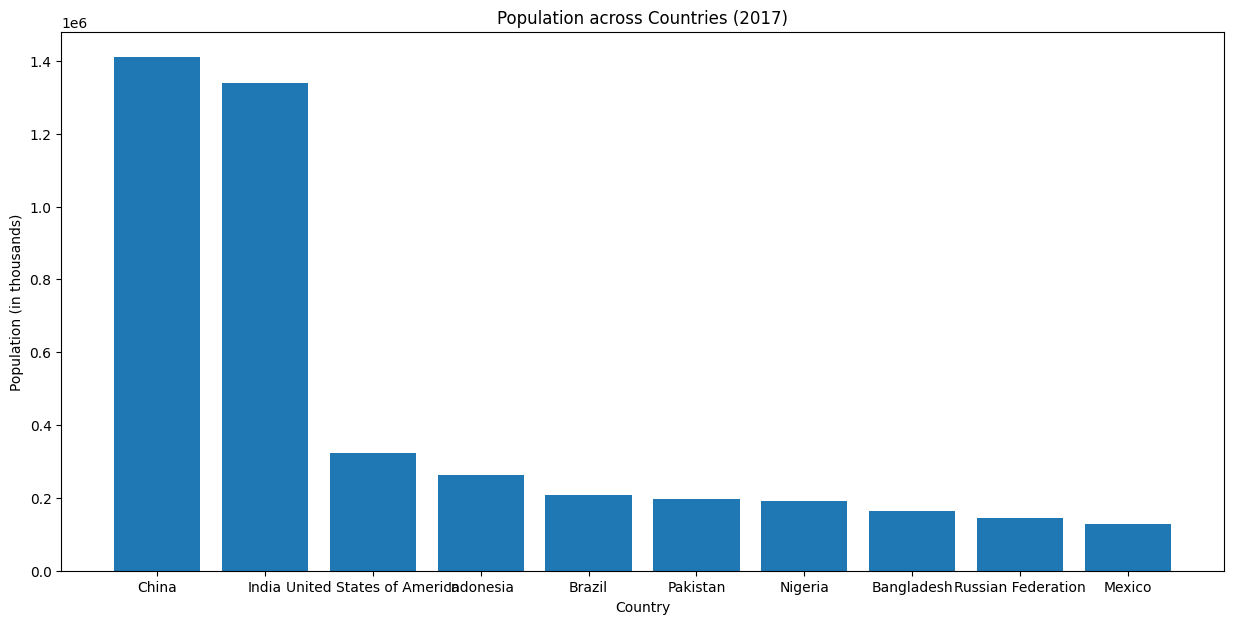

In [53]:
sorted_df = country_df.sort_values("Population in thousands", ascending=False)
top_10 = sorted_df.head(10)
plt.figure(figsize=(15, 7))
plt.bar(top_10['country'], top_10['Population in thousands'])

# Customize the plot
plt.title("Population across Countries (2017)")
plt.xlabel("Country")
plt.ylabel("Population (in thousands)")

Chaina has more population as per 2017 as per the above chart

###Part 2.2.b - Perform bivariate and multivariate analysis and share your insights. Any 2 plots which explains the relationship better

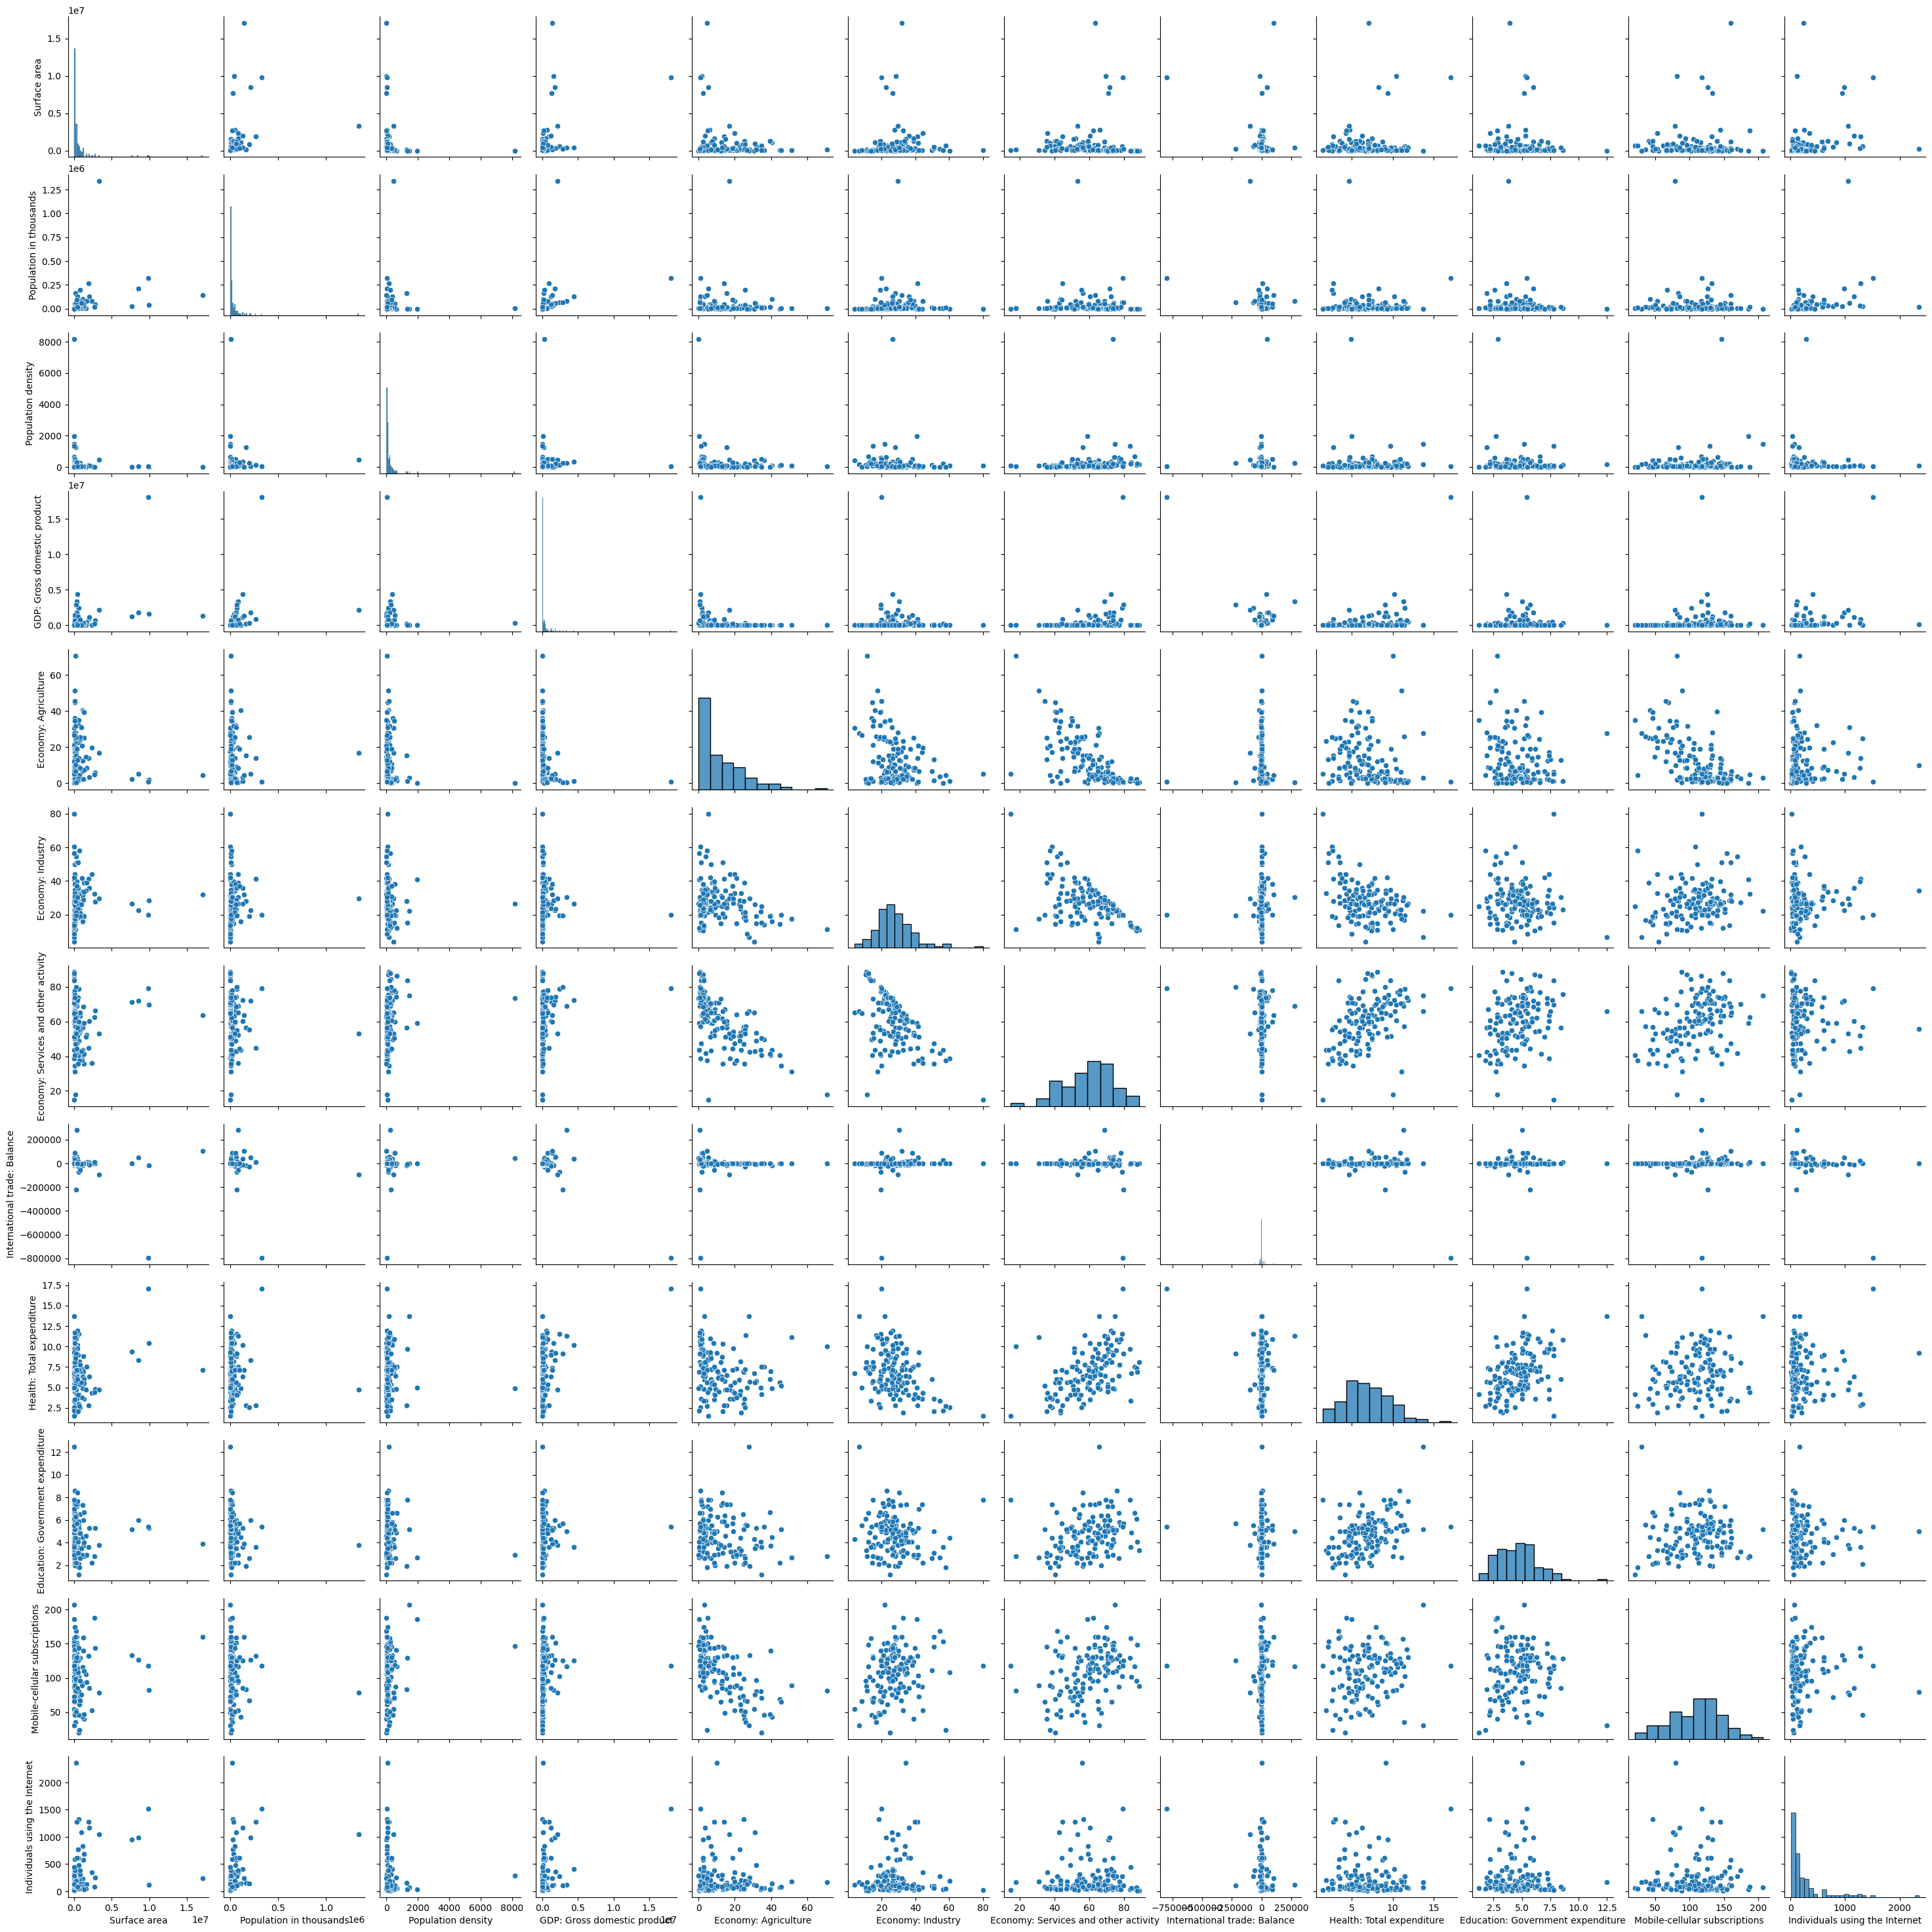

In [54]:
df = country_df.dropna(inplace=False)
sns.pairplot(df)

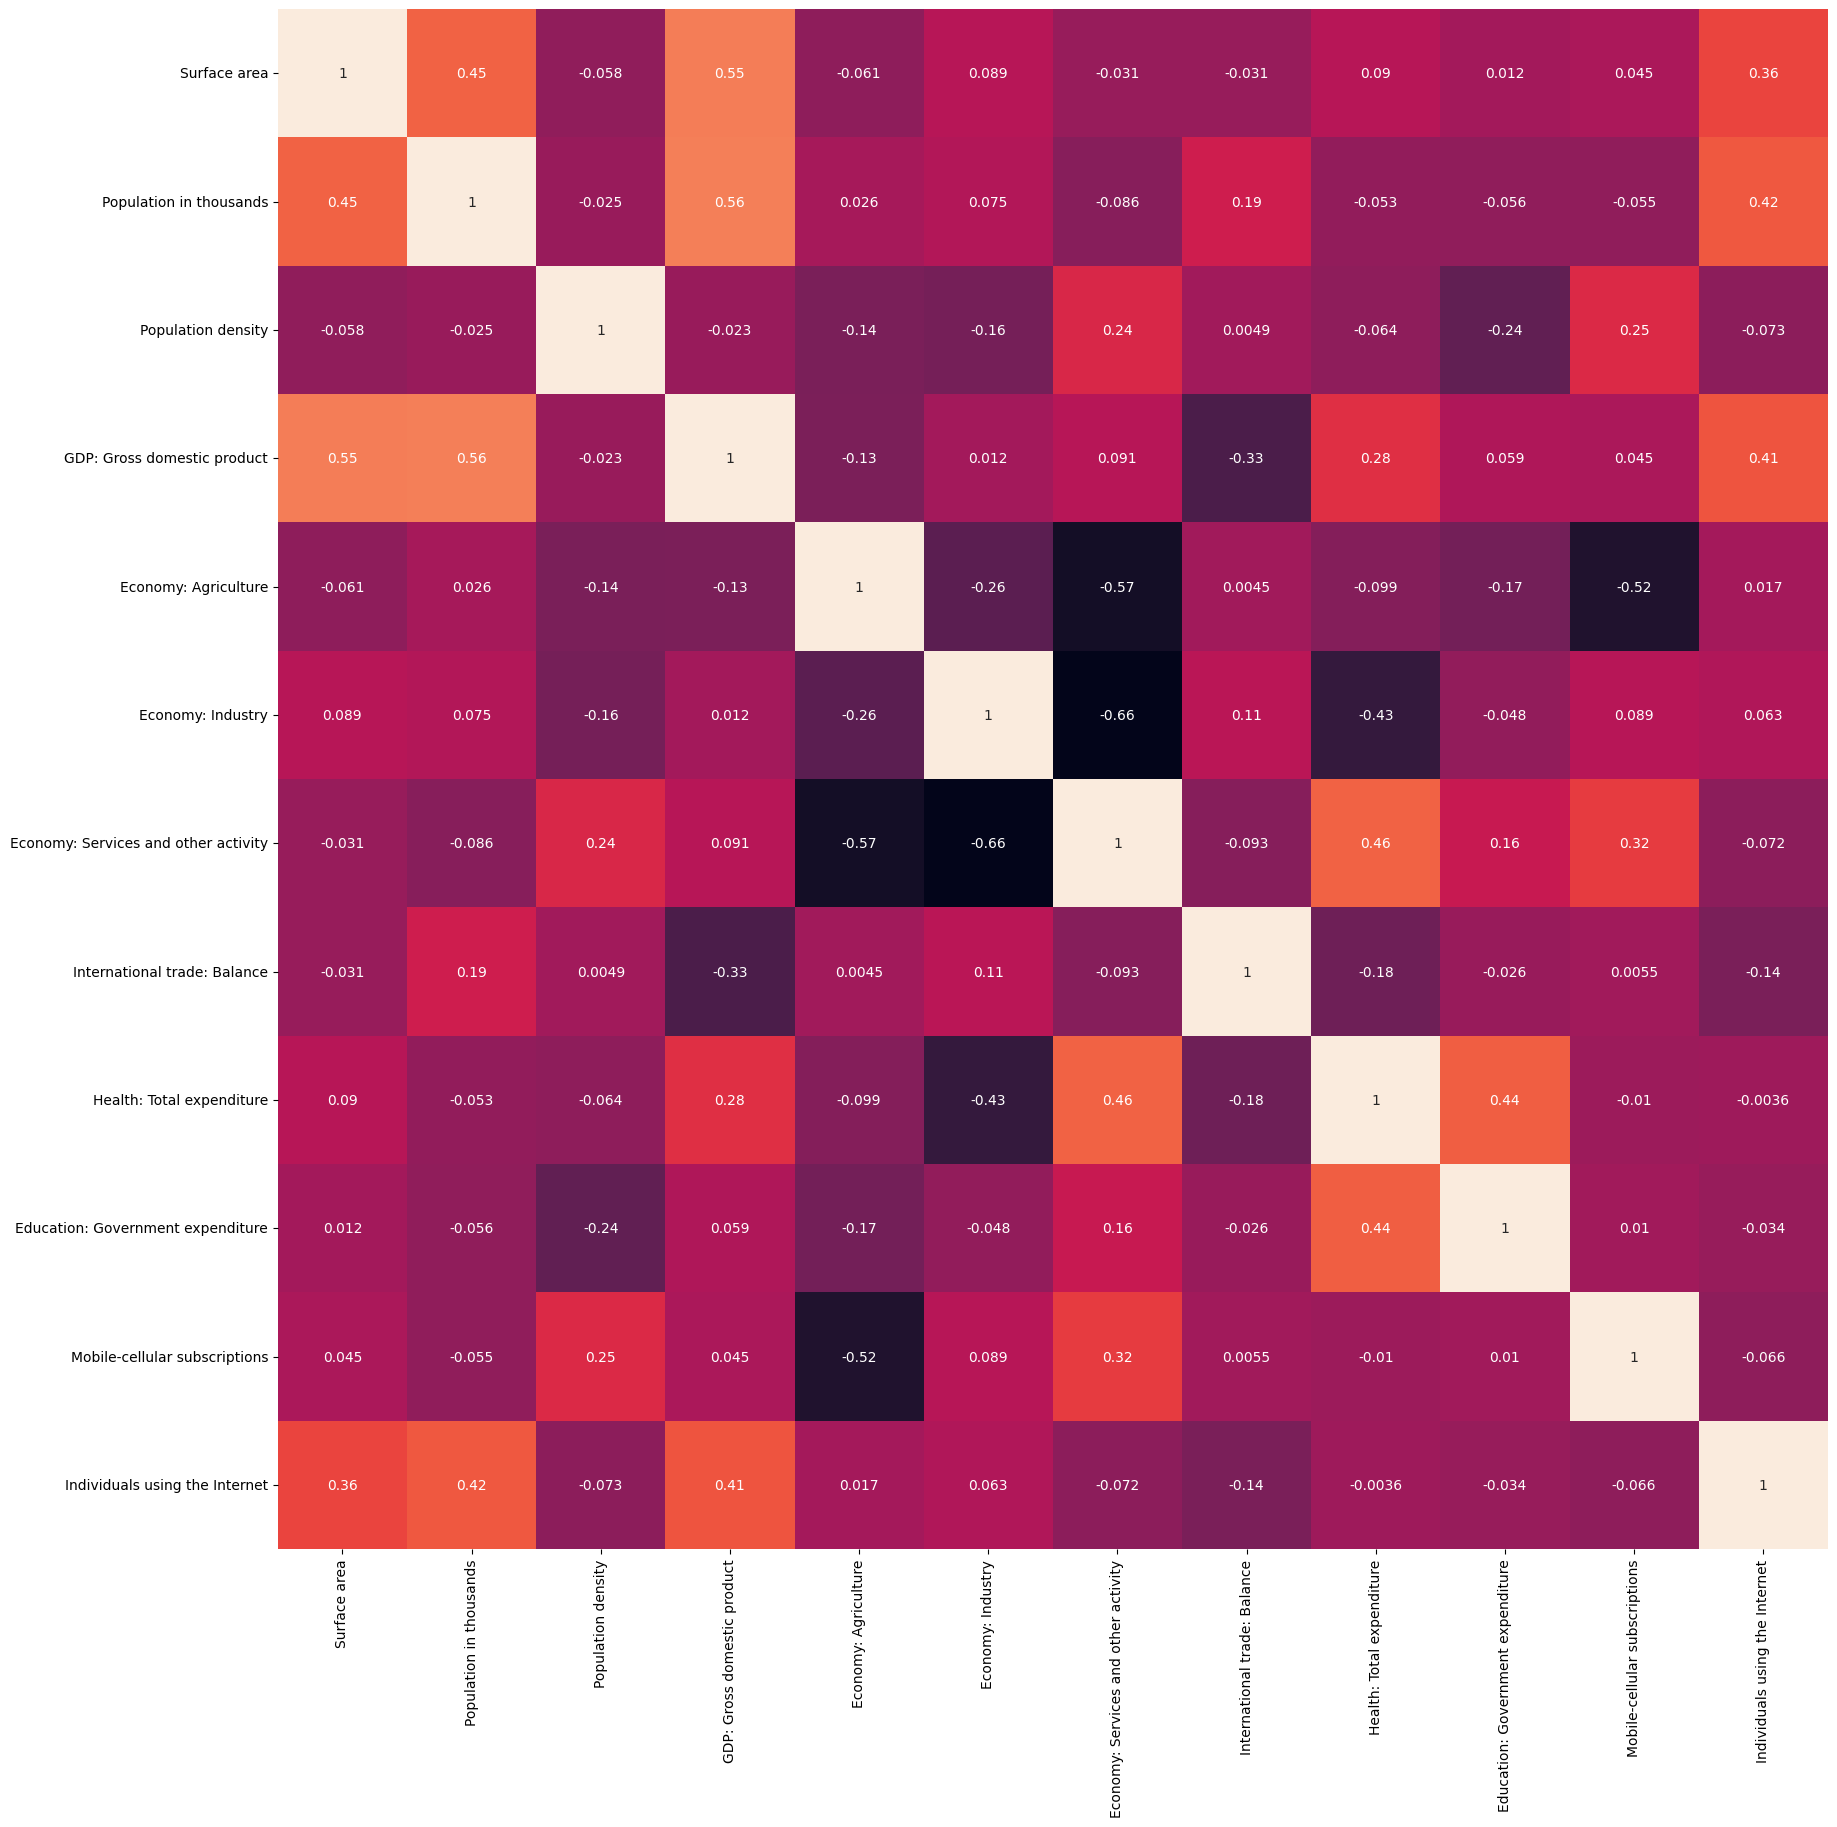

In [55]:
plt.figure(figsize=(20, 20))
plt.xticks(rotation=30)
sns.heatmap(data = country_df.corr(), annot=True,cbar=False);

Insights

1. Surface area has a moderate positive correlation with GDP: Gross domestic product (0.55), indicating that countries with larger surface areas tend to have higher GDP.

2. Population in thousands has a positive correlation with both Surface area (0.45) and GDP: Gross domestic product (0.56), suggesting that countries with larger populations tend to have larger surface areas and higher GDP.

3. Economy: Agriculture has a negative correlation with Economy: Industry (-0.26) and Economy: Services and other activity (-0.57), indicating that countries with a higher share of their economy in agriculture tend to have a lower share in industry and services.

4. Economy: Industry has a negative correlation with Economy: Services and other activity (-0.66), implying that countries with a higher share of their economy in industry tend to have a lower share in services.

5. International trade: Balance has a negative correlation with GDP: Gross domestic product (-0.33), suggesting that countries with higher trade deficits tend to have lower GDP.

6. Health: Total expenditure has a positive correlation with Education: Government expenditure (0.44), indicating that countries with higher health expenditure also tend to have higher education expenditure.

7. Mobile-cellular subscriptions and Individuals using the Internet have a positive correlation (0.32), suggesting that countries with higher mobile subscriptions also tend to have a higher percentage of individuals using the internet.

##Part 2.3 Data Pre-processing

###Part 2.3.a - Check if the data has any missing values, if any, impute those with suitable approach

In [56]:
print('Missing values before imputation')
missing_values = country_df.isnull().sum()
print(missing_values)

Missing values before imputation
country                                  0
Region                                   0
Surface area                             3
Population in thousands                  0
Population density                       0
GDP: Gross domestic product             21
Economy: Agriculture                    23
Economy: Industry                       21
Economy: Services and other activity    21
International trade: Balance            19
Health: Total expenditure               39
Education: Government expenditure       81
Mobile-cellular subscriptions           20
Individuals using the Internet           1
dtype: int64


In [57]:
# get all the coulmn which has the missing data
columns_with_missing_data = country_df.columns[country_df.isnull().any()]

# replace with mode
for column in columns_with_missing_data:
  country_df[column].fillna(country_df[column].mode()[0], inplace=True)

# print all the missing value after imputation
print('Missing values after imputation')
missing_values = country_df.isnull().sum()
print(missing_values)

Missing values after imputation
country                                 0
Region                                  0
Surface area                            0
Population in thousands                 0
Population density                      0
GDP: Gross domestic product             0
Economy: Agriculture                    0
Economy: Industry                       0
Economy: Services and other activity    0
International trade: Balance            0
Health: Total expenditure               0
Education: Government expenditure       0
Mobile-cellular subscriptions           0
Individuals using the Internet          0
dtype: int64


###Part 2.3.b - b. Scale all the numeric variables in the data

In [58]:
numeric_columns = country_df.select_dtypes(include=['float64', 'int64']).columns
country_df[numeric_columns] = country_df[numeric_columns].apply(zscore)
country_df.head()

,country,Region,Surface area,Population in thousands,Population density,GDP: Gross domestic product,Economy: Agriculture,Economy: Industry,Economy: Services and other activity,International trade: Balance,Health: Total expenditure,Education: Government expenditure,Mobile-cellular subscriptions,Individuals using the Internet
0,Afghanistan,SouthernAsia,0.037845,0.020854,-0.177549,-0.204124,1.084254,-0.294372,-0.345672,-0.019928,0.633878,-1.070246,-1.061592,-0.532848
1,Albania,SouthernEurope,-0.312478,-0.224289,-0.154727,-0.210040,1.008616,-0.080091,-0.444136,-0.028466,-0.257851,-0.936429,0.019527,-0.234861
2,Algeria,NorthernAfrica,1.008283,0.064378,-0.193677,-0.106182,0.151386,0.816715,-0.517984,-0.234304,0.246169,0.401744,0.178799,-0.217930
3,American Samoa,Polynesia,-0.328503,-0.245901,-0.080260,-0.217840,-0.815099,-0.437227,-1.324157,-0.005182,-0.374164,0.401744,-0.446223,-0.363537
4,Andorra,SouthernEurope,-0.328352,-0.245743,-0.129991,-0.215956,-0.831908,-1.286415,1.826689,-0.007700,0.595107,-1.070246,-0.422091,-0.631048


##Part 2.4 Hierarchical Clustering

###Part 2.4.a - Apply Hierarchical clustering to the scaled data.

In [59]:
numerical_df = country_df.select_dtypes(include='number')
numerical_df.head()

,Surface area,Population in thousands,Population density,GDP: Gross domestic product,Economy: Agriculture,Economy: Industry,Economy: Services and other activity,International trade: Balance,Health: Total expenditure,Education: Government expenditure,Mobile-cellular subscriptions,Individuals using the Internet
0,0.037845,0.020854,-0.177549,-0.204124,1.084254,-0.294372,-0.345672,-0.019928,0.633878,-1.070246,-1.061592,-0.532848
1,-0.312478,-0.224289,-0.154727,-0.210040,1.008616,-0.080091,-0.444136,-0.028466,-0.257851,-0.936429,0.019527,-0.234861
2,1.008283,0.064378,-0.193677,-0.106182,0.151386,0.816715,-0.517984,-0.234304,0.246169,0.401744,0.178799,-0.217930
3,-0.328503,-0.245901,-0.080260,-0.217840,-0.815099,-0.437227,-1.324157,-0.005182,-0.374164,0.401744,-0.446223,-0.363537
4,-0.328352,-0.245743,-0.129991,-0.215956,-0.831908,-1.286415,1.826689,-0.007700,0.595107,-1.070246,-0.422091,-0.631048


In [60]:
model = AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage = 'average')
model.fit(numerical_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=3)

In [61]:
country_df['label'] = model.labels_
country_df.head()

,country,Region,Surface area,Population in thousands,Population density,GDP: Gross domestic product,Economy: Agriculture,Economy: Industry,Economy: Services and other activity,International trade: Balance,Health: Total expenditure,Education: Government expenditure,Mobile-cellular subscriptions,Individuals using the Internet,label
0,Afghanistan,SouthernAsia,0.037845,0.020854,-0.177549,-0.204124,1.084254,-0.294372,-0.345672,-0.019928,0.633878,-1.070246,-1.061592,-0.532848,0
1,Albania,SouthernEurope,-0.312478,-0.224289,-0.154727,-0.210040,1.008616,-0.080091,-0.444136,-0.028466,-0.257851,-0.936429,0.019527,-0.234861,0
2,Algeria,NorthernAfrica,1.008283,0.064378,-0.193677,-0.106182,0.151386,0.816715,-0.517984,-0.234304,0.246169,0.401744,0.178799,-0.217930,0
3,American Samoa,Polynesia,-0.328503,-0.245901,-0.080260,-0.217840,-0.815099,-0.437227,-1.324157,-0.005182,-0.374164,0.401744,-0.446223,-0.363537,0
4,Andorra,SouthernEurope,-0.328352,-0.245743,-0.129991,-0.215956,-0.831908,-1.286415,1.826689,-0.007700,0.595107,-1.070246,-0.422091,-0.631048,0


###Part 2.4.b - Identify the number of optimum clusters using Dendrogram and briefly describe them

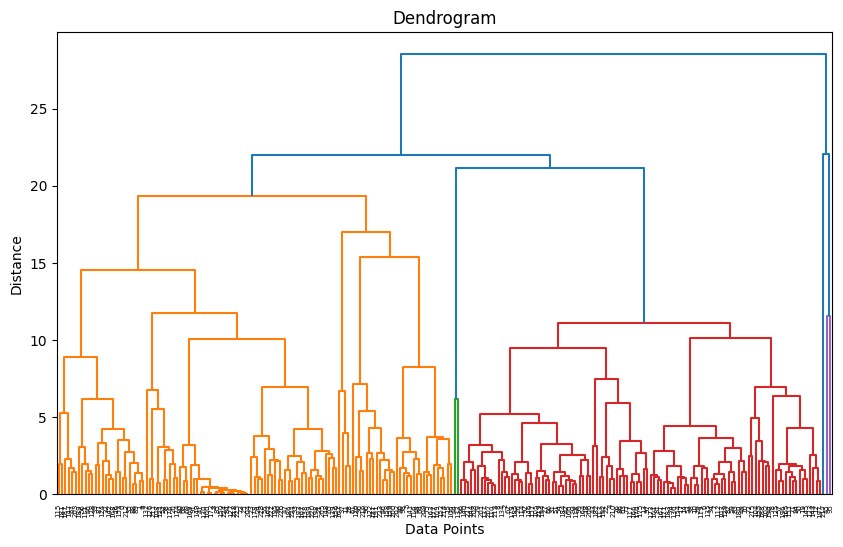

In [62]:
Z = linkage(numerical_df, 'ward', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [63]:
n_clusters = 3
model = AgglomerativeClustering(n_clusters=n_clusters)
model.fit(numerical_df)

numerical_df['Cluster'] = model.labels_
cluster_profile = numerical_df.groupby('Cluster').mean()
cluster_profile

,Surface area,Population in thousands,Population density,GDP: Gross domestic product,Economy: Agriculture,Economy: Industry,Economy: Services and other activity,International trade: Balance,Health: Total expenditure,Education: Government expenditure,Mobile-cellular subscriptions,Individuals using the Internet
Cluster,,,,,,,,,,,,
0,-0.052069,-0.098984,0.001447,-0.091008,0.001486,-0.003326,-0.001484,0.022810,-0.013046,-0.000004,0.002901,-0.045653
1,3.288268,10.088387,-0.070674,4.280647,0.227024,0.665925,-0.459521,3.113164,-0.568018,-0.166979,-0.472768,2.934633
2,5.191048,2.193525,-0.185766,12.006602,-0.789887,-0.580081,1.254367,-11.381375,4.084481,0.334835,0.289807,4.448270


###Part 2.4.d - Share your insights on cluster profiles and also give any 2 business recommendations

##Cluster 0:

1. This cluster has countries with relatively higher surface area, population, and GDP.
2. The economy of these countries is primarily driven by agriculture, industry, and services.
3. They have a positive international trade balance, indicating a trade surplus.
These countries have relatively higher health and education expenditures.
4. Mobile-cellular subscriptions and internet usage are also higher in this cluster.

##Cluster 1:

1. This cluster has countries with relatively lower values for most of the features.
2. The economy of these countries is less diverse, with lower contributions from agriculture, industry, and services.
3. International trade balance is close to zero, indicating a relatively balanced trade.
4. Health and education expenditures are moderate in this cluster.
5. Mobile-cellular subscriptions and internet usage are also average.

##Cluster 2:

1. This cluster represents countries with moderate values for most of the features.
2. The economy of these countries has a higher emphasis on agriculture, while the contributions from industry and services are relatively lower.
3. International trade balance is close to zero, indicating a relatively balanced trade.
4. Health and education expenditures are comparatively lower in this cluster.
5. Mobile-cellular subscriptions and internet usage are average.


###Based on these cluster profiles, here are two business recommendations:

1. Market Expansion: Businesses looking for opportunities to expand their market can focus on countries in Cluster 0, which have higher surface area, population, and GDP. These countries show a strong presence in various sectors and have a positive international trade balance. They may offer potential markets for business growth and expansion.

2. Technology Adoption: Companies operating in Cluster 1 and Cluster 2 countries can consider leveraging the moderate levels of mobile-cellular subscriptions and internet usage. These countries may present opportunities for technology-driven products and services, such as mobile applications, e-commerce platforms, or digital marketing solutions. By focusing on improving technology adoption and catering to the needs of these markets, businesses can tap into potential customer bases.

##Part 2.5 Dimensionality Reduction using PCA

###Part 2.5.a - Apply PCA on the scaled data with 2 components

Explained Variance Ratio of Principal Component 1: 0.20638107630354455
Explained Variance Ratio of Principal Component 2: 0.17660681541755624


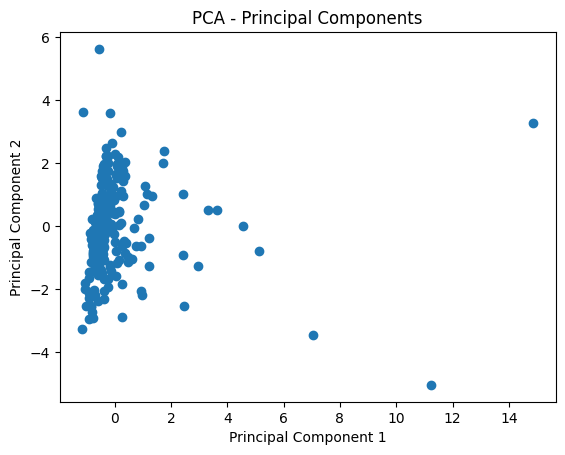

In [64]:
pca = PCA(n_components=2)
pca.fit(numerical_df)
principal_components = pca.transform(numerical_df)
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio of each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained Variance Ratio of Principal Component {i+1}: {ratio}")

# Optional: Plot the principal components to visualize the data
import matplotlib.pyplot as plt

plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Components')
plt.show()

###Part 2.5.b - How much Cumulative Variance is Explained by 2 PCA’s? 

In [65]:
cumulative_variance = np.cumsum(explained_variance_ratio[:2])
cumulative_variance

array([0.20638108, 0.38298789])

###Part 2.5.c - Plot a scatter plot on PCA’s formed i.e. PCA 1 and PCA 2 with hue as cluster profiles from

In [66]:
n_clusters = 3
model = AgglomerativeClustering(n_clusters=n_clusters)
model.fit(principal_df)
principal_df['Cluster'] = model.labels_
principal_df

,Principal Component 1,Principal Component 2,Cluster
0,-0.378652,-0.666494,0
1,-0.652239,-0.707149,0
2,0.407357,-0.547413,0
3,-0.714875,-0.432694,0
4,-0.333105,1.903113,2
...,...,...,...
224,-0.718061,-0.453258,0
225,-0.698295,-0.453793,0
226,-0.179353,-1.233034,0
227,-0.394351,-0.455259,0


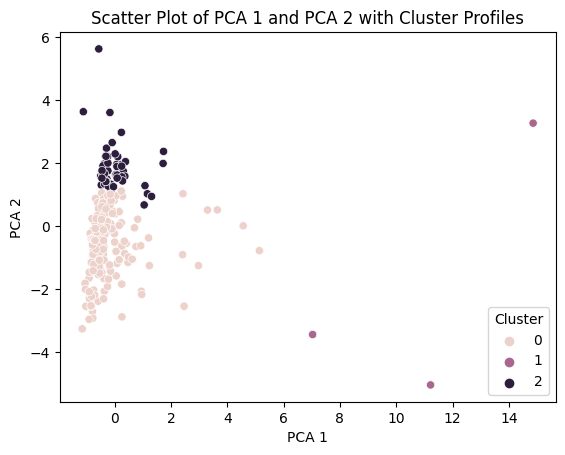

In [67]:
sns.scatterplot(x=principal_df['Principal Component 1'],y=  principal_df['Principal Component 2'], hue='Cluster',data=principal_df)

# Add labels and title
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Scatter Plot of PCA 1 and PCA 2 with Cluster Profiles')

# Show the plot
plt.show()

###Part 2.5.d - Mention which are the major clusters

<Axes: xlabel='Principal Component 1', ylabel='Principal Component 2'>

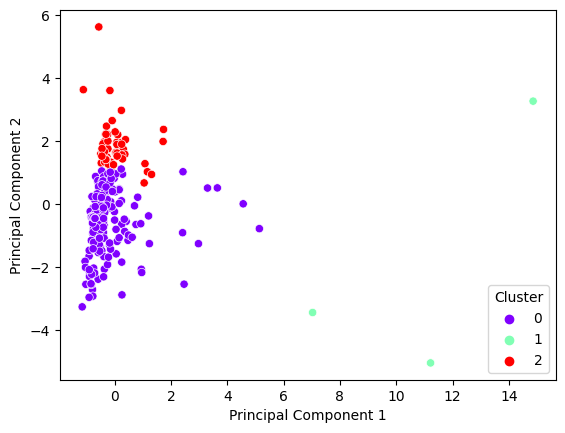

In [74]:
sns.scatterplot( data=principal_df, x="Principal Component 1", y="Principal Component 2", hue=principal_df["Cluster"], palette="rainbow")

In this case, we can observe that, Comparing the PC values, we can see that Cluster 0 and Cluster 1 has significantly high Therefore, Cluster 0 and cluster 1 can be considered the major clusters.

In [75]:
%%shell
jupyter nbconvert --to html /content/Unsupervised_Learning_Project.ipynb

[NbConvertApp] Converting notebook /content/Unsupervised_Learning_Project.ipynb to html
[NbConvertApp] Writing 3073861 bytes to /content/Unsupervised_Learning_Project.html
